<b>Importing Librabries</b>

In [1]:
import tensorflow as tf
import cv2 as cv
import os
from keras.layers import Dropout,Conv2D,Flatten,MaxPooling2D,Dense
from keras.models import Sequential,Model
from keras.applications import ResNet50V2
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

Using TensorFlow backend.


<b>Defining Hyper Parameters</b>

In [2]:
params = {
    'TRAIN_DATASET':'data/train_filtered',
    'VAL_DATASET':'data/val_filtered',
    'epochs':20,
    'batch_size':16,
    'target_size':[256,256]
}

<b>Applying Image Augmentation and Preprocessing</b>


In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    channel_shift_range=0.3,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1. / 255,
)

val_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
)

In [4]:
train = train_datagen.flow_from_directory(
    directory = params['TRAIN_DATASET'],
    target_size=params['target_size'],
    class_mode='categorical',
    shuffle=True,
    batch_size=params['batch_size']
)

validation = train_datagen.flow_from_directory(
    directory = params['VAL_DATASET'],
    target_size=params['target_size'],
    class_mode='categorical',
    shuffle=True,
    batch_size=params['batch_size']
)

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


<b>Setting Up ResNet50V2 Model for Transfer Learning</b>

In [5]:
resnet_model = ResNet50V2(
    input_shape=(params['target_size'][0], params['target_size'][1], 3),
    include_top=False,
    weights="imagenet"
)

In [6]:
for layer in resnet_model.layers:
    layer.trainable = False 

<b>Adding Dense Layer at the bottom of ResNet50V2 Model</b>

In [11]:
last_layer = resnet_model.output
last_layer = Flatten()(last_layer)
last_layer = Dense(120,activation='softmax')(last_layer)

model = Model(resnet_model.input, last_layer)#first layer,last layer

<b>Configuring Model with callbacks and other hyper parameter</b>

In [15]:
checkpoint = ModelCheckpoint(
                             'Model/resnet_model/resent_classifier.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(
                          monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

callbacks = [earlystop,checkpoint,learning_rate_reduction]

In [16]:
model.compile(optimizer = 'adam', 
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: &quot;model_2&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
__________________________________________________________________________________

<b>Training Of the model and the actual epoch is 29 as for first run it do 9 epochs and for second run it does 20</b>

In [17]:
history = model.fit_generator(
    train,
    epochs=params['epochs'],
    validation_data=validation,
    callbacks=callbacks
)

Epoch 1/20
512/512 [==============================] - 214s 418ms/step - loss: 50.5174 - accuracy: 0.4191 - val_loss: 111.9970 - val_accuracy: 0.3611

Epoch 00001: val_loss improved from inf to 111.99703, saving model to Model/resnet_model/resent_classifier.h5
Epoch 2/20
512/512 [==============================] - 207s 405ms/step - loss: 52.1026 - accuracy: 0.4219 - val_loss: 103.2092 - val_accuracy: 0.3796

Epoch 00002: val_loss improved from 111.99703 to 103.20919, saving model to Model/resnet_model/resent_classifier.h5
Epoch 3/20
512/512 [==============================] - 210s 409ms/step - loss: 51.5836 - accuracy: 0.4227 - val_loss: 178.1581 - val_accuracy: 0.3645

Epoch 00003: val_loss did not improve from 103.20919
Epoch 4/20
512/512 [==============================] - 205s 401ms/step - loss: 52.2530 - accuracy: 0.4359 - val_loss: 180.4696 - val_accuracy: 0.3841

Epoch 00004: val_loss did not improve from 103.20919
Epoch 5/20
512/512 [==============================] - 206s 403ms/ste

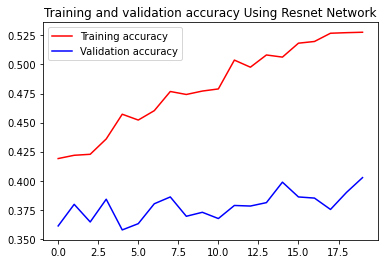

&lt;Figure size 432x288 with 0 Axes&gt;

In [23]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy Using Resnet Network')
plt.legend()
plt.figure()


plt.show()

&lt;Figure size 432x288 with 0 Axes&gt;

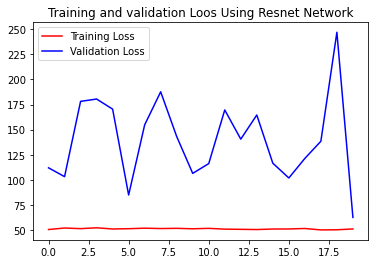

&lt;Figure size 432x288 with 0 Axes&gt;

In [24]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loos Using Resnet Network')
plt.legend()
plt.figure()